In [2]:
import numpy as np
import h5py
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Input, Embedding
from keras.layers import Dense, Merge, Dropout
from keras.layers import LSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.layers import Lambda
import pickle

Using TensorFlow backend.


In [3]:
alphabet = "NACGT"
vocab_size = len(alphabet)
time_steps = 100
embedding_size = 300 # for embedding layer, maybe remove
dense_size = 300
category = 10 # size of Y_vector

genome_input_shape = (100,)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Embedding(vocab_size, embedding_size, input_length=time_steps)(input)
    x = Bidirectional(LSTM(units=300, return_sequences=True))(x)
    x = Dropout(0.50)(x)
    x = Bidirectional(LSTM(units=300))(x)
    x = Dropout(0.50)(x)

    x = Dense(dense_size, activation='relu')(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dense(category, activation='linear')(x)
    return Model(input, x)


model_makes_embedding = create_base_network(genome_input_shape)

input_a = Input(shape=genome_input_shape)
input_b = Input(shape=genome_input_shape)

processed_a = model_makes_embedding(input_a)
processed_b = model_makes_embedding(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model_twin_sequences = Model([input_a, input_b], distance)

model_twin_sequences.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

model_twin_sequences.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 10)            3879910                                      
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 1)             0                                            
Total params: 3,879,910
Trainable params: 3,879,910
Non-trainable params: 0
_______________

In [3]:
h5f = h5py.File('X_train_twin_sequences_a.h5','r')
X_train_a = h5f['X_a'][:]
h5f.close()
h5f = h5py.File('X_train_twin_sequences_b.h5','r')
X_train_b = h5f['X_b'][:]
h5f.close()
h5f = h5py.File('Y_train_twin_sequences.h5','r')
Y_train = h5f['Y'][:]
h5f.close()
print(X_train_a.shape)
print(Y_train.shape)
print(X_train_a[1000:1001])
print(X_train_b[1000:1001])
print(Y_train[:1])

(99431, 100)
(99431,)
[[1 2 3 1 1 1 3 2 3 4 3 3 3 3 1 3 2 1 1 1 2 1 3 3 1 4 4 1 3 1 4 1 2 2 2 4 3
  3 4 1 3 4 2 2 1 2 3 2 2 3 4 1 1 1 2 3 1 4 3 1 1 4 3 2 4 1 3 4 4 3 4 2 1 3
  3 4 1 3 2 4 4 3 2 4 1 4 4 4 3 3 4 3 1 2 3 2 1 3 2 4]]
[[2 3 2 3 1 1 1 3 2 3 4 3 3 3 3 1 3 2 1 1 1 2 1 3 3 1 4 4 1 3 1 4 1 2 2 2 4
  3 3 4 1 3 4 2 2 1 2 3 2 4 3 4 1 1 1 2 3 1 4 3 4 3 4 3 2 4 3 3 1 4 3 4 4 3
  3 3 1 1 1 2 4 4 1 3 4 4 4 2 4 2 1 3 4 3 4 2 3 1 1 3]]
[ 0.09754117]


In [9]:
# Resource exhausted: OOM when allocating tensor
#model_twin_sequences.fit([X_train_a[:1], X_train_b[:1]], Y_train[:1], batch_size=128)
model_twin_sequences.fit([X_train_a, X_train_b], Y_train, batch_size=128)

Epoch 1/1
99586/99586 [==============================] - 2385s - loss: 0.0015 - mean_squared_error: 0.0015  


In [11]:
for myset in range(1,2):
    history = model_twin_sequences.fit([X_train_a[:1], X_train_b[:1]], Y_train[:1], batch_size=128, shuffle=True, epochs=1)
    model_twin_sequences.save('Jan11_model_twin_sequences_set' + str(myset) + '.h5')
    model_makes_embedding.save('Jan11_model_makes_embedding_set' + str(myset) + '.h5')
    with open('Jan11_model_twin_sequences_set' + str(myset) + 'history.txt', 'wb') as handle:
        pickle.dump(history.history, handle)

Epoch 1/1
1/1 [==============================] - 3s - loss: 9.3139e-04 - mean_squared_error: 9.3139e-04


In [4]:
# load the model and try to do a prediction
from keras.models import load_model
trained_twin_model = load_model('Jan15_model_twin_sequences_set4.h5')

In [5]:
trained_twin_model.predict([X_train_a[:10], X_train_b[:10]])

array([[ 0.06576788],
       [ 0.01736797],
       [ 0.10507537],
       [ 0.02371137],
       [ 0.05111643],
       [ 0.03630906],
       [ 0.03503447],
       [ 0.04084076],
       [ 0.05925367],
       [ 0.04531624]], dtype=float32)

In [6]:
print(Y_train[:10])

[ 0.09754117  0.03762848  0.11574222  0.10442022  0.05196745  0.07465029
  0.06504191  0.07884294  0.09664609  0.10845492]


In [15]:
h5f = h5py.File('X_test_seen_leaf_pairs_twin_sequences_a.h5','r')
X_test_a = h5f['X_a'][:]
h5f.close()
h5f = h5py.File('X_test_seen_leaf_pairs_twin_sequences_b.h5','r')
X_test_b = h5f['X_b'][:]
h5f.close()
predictions = trained_twin_model.predict([X_test_a, X_test_b])
h5f_Y = h5py.File('test_evaluation_Jan15_model_twin_sequences.h5', 'w')
h5f_Y.create_dataset('Y', data=predictions)
h5f_Y.close()

loaded
[0.0015254691588983656, 0.0015076220762050808, 0.0014923455268876554, 0.0014647507661369201, 0.001422291532153007, 0.0013823993185363215, 0.001373096540039374, 0.0013595330245138606, 0.0013643815060747587, 0.0013437856325802214, 0.0013377889692998037, 0.0013360963498175444, 0.0013269741348180611, 0.0013249459213460898, 0.0013215323288767887, 0.001320518268542842, 0.0013187901275485143, 0.0013097980133816996, 0.001314101632173371, 0.0013146021075890605]


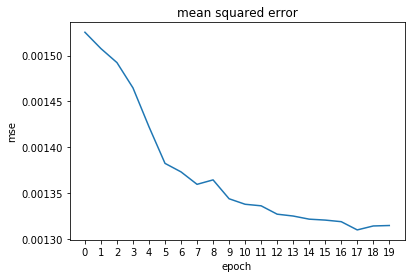

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.plot(history_epoch_1_50_100K['mean_squared_error'] + history_epoch_50_100_100K['mean_squared_error'])
#plt.plot(history_epoch_1_50_100K['val_mean_squared_error'] + history_epoch_50_100_100K['val_mean_squared_error'])
mse = []
for myset in range(1,5):
    with open('Jan15_model_twin_sequences_set' + str(myset) + '_history.txt', 'rb') as handle:
        saved_history = pickle.loads(handle.read())
        mse += saved_history['mean_squared_error']
print("loaded")
print(mse)
plt.plot(mse)
plt.title('mean squared error')
plt.xticks(np.arange(0, 20, 1))
plt.ylabel('mse')
plt.xlabel('epoch')